In [25]:
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential, layers
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn
from imblearn.under_sampling import RandomUnderSampler
from keras.regularizers import l2
from imblearn.over_sampling import SMOTE



In [26]:
df = pd.read_csv("/ssd003/projects/pets/datasets/homecredit_train.csv")

<AxesSubplot:>

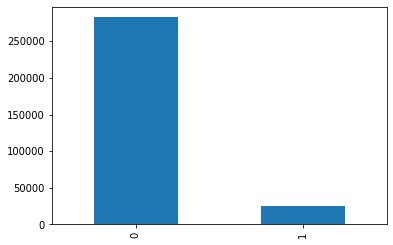

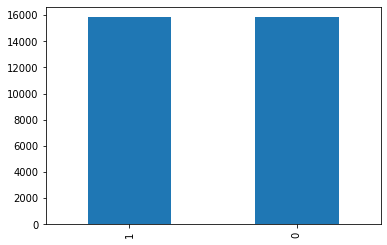

In [27]:
fig, ax = plt.subplots()
df['target'].value_counts().plot(ax=ax, kind='bar')

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Oversampling target labels
max_size = train_df['target'].value_counts().max()

# lst = [train_df]
# for class_index, group in train_df.groupby('target'):
#     lst.append(group.sample(max_size-len(group), replace=True))
# X_train = pd.concat(lst)

X_train = train_df.drop(['target'], axis=1)
y_train = train_df['target']

rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

X_test = test_df.drop(['target'], axis=1)
y_test = test_df['target']

X_val = val_df.drop(['target'], axis=1)
y_val = val_df['target']

fig, ax = plt.subplots()
y_train.value_counts().plot(ax=ax, kind='bar')



In [28]:
scaler = StandardScaler()
X_train_transform = scaler.fit_transform(X_train)
X_val_transform = scaler.transform(X_val)
X_test_transform = scaler.transform(X_test)

X_train_transform = pd.DataFrame(X_train_transform,columns = X_train.columns)
X_val_transform = pd.DataFrame(X_val_transform,columns = X_train.columns)
X_test_transform = pd.DataFrame(X_test_transform, columns = X_train.columns)

# BASELINE MODEL

In [22]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model = Sequential([
        layers.Dense(1024, activation="relu", input_shape=(X_train.shape[-1],), kernel_regularizer=l2(0.001)),
#         layers.Dropout(.4, input_shape=(1000,)),
        layers.Dense(512, activation="relu", kernel_regularizer=l2(0.001)),
#         layers.Dropout(.4, input_shape=(1000,)),
        layers.Dense(256, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dropout(.4, input_shape=(1000,)),
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(1,activation='sigmoid')])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=METRICS)

In [24]:
history = model.fit(X_train_transform, y_train, epochs=50, batch_size=128, validation_data=(X_val_transform, y_val))

Epoch 1/50
2828/2828 [==============================] - 24s 9ms/step - loss: 0.5558 - tp: 135785.0000 - fp: 51816.0000 - tn: 129156.0000 - fn: 45187.0000 - accuracy: 0.7320 - precision: 0.7238 - recall: 0.7503 - auc: 0.8071 - prc: 0.7913 - val_loss: 0.5873 - val_tp: 2204.0000 - val_fp: 12002.0000 - val_tn: 33158.0000 - val_fn: 1838.0000 - val_accuracy: 0.7187 - val_precision: 0.1551 - val_recall: 0.5453 - val_auc: 0.6934 - val_prc: 0.1673
Epoch 2/50
2828/2828 [==============================] - 23s 8ms/step - loss: 0.5169 - tp: 140003.0000 - fp: 44825.0000 - tn: 136147.0000 - fn: 40969.0000 - accuracy: 0.7630 - precision: 0.7575 - recall: 0.7736 - auc: 0.8427 - prc: 0.8337 - val_loss: 0.5892 - val_tp: 2144.0000 - val_fp: 12418.0000 - val_tn: 32742.0000 - val_fn: 1898.0000 - val_accuracy: 0.7090 - val_precision: 0.1472 - val_recall: 0.5304 - val_auc: 0.6858 - val_prc: 0.1564
Epoch 3/50
2828/2828 [==============================] - 23s 8ms/step - loss: 0.4922 - tp: 142906.0000 - fp: 41572.

KeyboardInterrupt: 

In [ ]:
scores = model.evaluate(X_test_transform, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

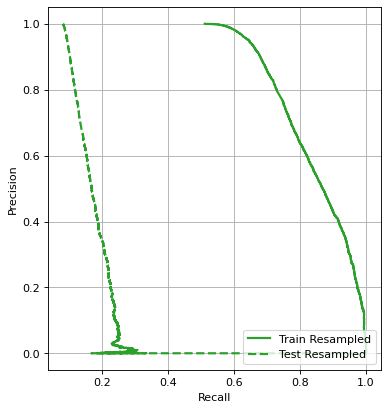

In [31]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
train_predictions_resampled = model.predict(X_train, batch_size=128)
test_predictions_resampled =  model.predict(X_test, batch_size=128)
plot_prc("Train Resampled", y_train, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", y_test, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')



# results = model.evaluate(X_test, y_test, batch_size=64)

In [9]:
y_pred = model.predict(X_test_transform)
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, np.rint(y_pred))

In [10]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["0","1"])

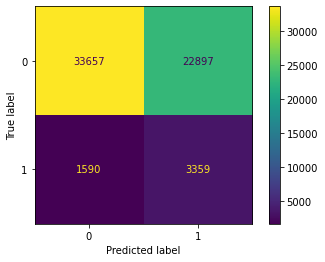

In [11]:
disp.plot()